In [3]:
import pandas as pd

In [4]:
data_path = "data/apple_quality.csv"

apple_quality = pd.read_csv(data_path)

In [5]:
print(apple_quality.head())

   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0     0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1     1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4     4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

    Acidity Quality  
0 -0.491590    good  
1 -0.722809    good  
2  2.621636     bad  
3  0.790723    good  
4  0.501984    good  


In [6]:
apple_quality = apple_quality.drop("A_id", axis=1)

yes_no_mapping = {'good': 1, 'bad': 0}
apple_quality.replace(yes_no_mapping, inplace=True)

In [7]:
X = apple_quality.drop("Quality", axis=1)
X = X.values

y = apple_quality["Quality"]
y = y.values

In [8]:
from sklearn.model_selection import train_test_split

# Train the model with 20% of the data being the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

In [9]:
from sklearn.neighbors import KNeighborsRegressor

In [10]:
# Create a K-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=3)

In [11]:
# Fit the model to the training data
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Get the train Root-Mean-Square-Error results
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
train_rmse = sqrt(mse)
print(train_rmse)

0.2040390757782549


In [13]:
# Get the test RMSE results
test_preds = knn_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = sqrt(test_mse)
print(test_rmse)

0.291070819942883


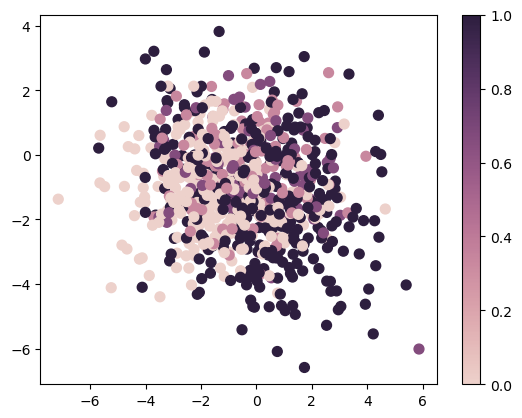

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the predictions
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

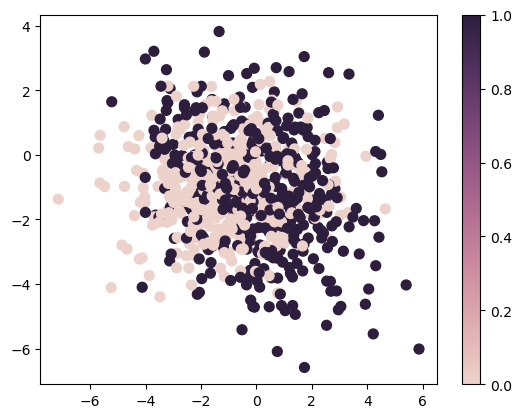

In [15]:
# Plot the actual data
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

## Time to optimize and improve the KNN model.  
First we will have to get the Best N-Neighbours for this dataset.

In [16]:
from sklearn.model_selection import GridSearchCV

# Search from N-Neighbors from 1 to 50
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [17]:
print(gridsearch.best_params_)

{'n_neighbors': 10}


In [18]:
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
print(train_rmse)

0.25041216024786017


In [19]:
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print(test_rmse)

0.27876961814372814


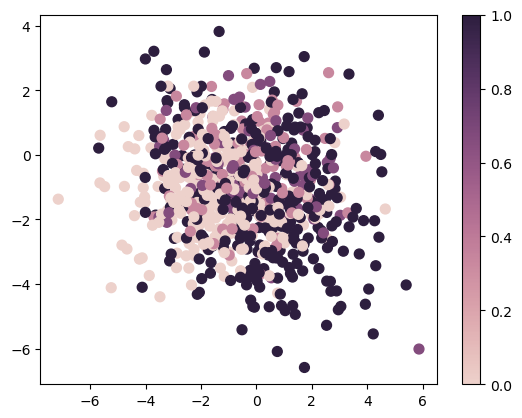

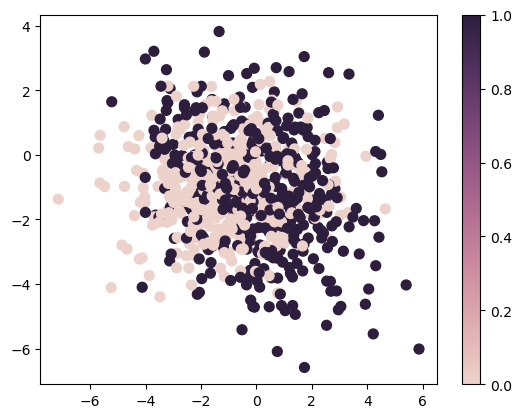

In [20]:
# Plot the new predictions and new test data
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap
)
f.colorbar(points)
plt.show()

## Lets add a Weighted Average of Neighbors Based on Distance to further improve the KNN model

In [21]:
parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"],
}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [22]:
print(gridsearch.best_params_)

{'n_neighbors': 10, 'weights': 'distance'}


In [23]:
# Now that we have a different GridSearchCV, we can now predict with better results
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print(test_rmse)

0.27583000634996274


There is an improvement for the Root-Mean-Square-Error for the KNN model with a weighted average:  
From: 

## Finally, lets we bagging to improve the KNN even further!

In [24]:
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(
    n_neighbors=best_k, weights=best_weights
)

In [25]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(X_test, y_test)

BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=10,
                                               weights='distance'),
                 n_estimators=100)

In [26]:
test_preds_grid = bagging_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print(test_rmse)

0.1130398827212174
